# Imports

In [1]:
# Code was run on Google Colab. Export files not available.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

# Set Hyperparameters

In [2]:
input_channels = 3
num_classes = 10

device = 'cuda:0'
lr = 1e-2
epochs = 80
batch_size = 32

# Image Transformation

In [3]:
# create a list of commands for transforming the image
img_transform = transforms.Compose([
    transforms.ToTensor(),     # convert image to tensor
    transforms.CenterCrop(28)  # crop from the center
])

#create a function that normalizes each image
def norm_image(data_sample):
  img_tensor = data_sample[0] # get the image values/tensors
  label = data_sample[1]      # label

  img_means = img_tensor.mean(axis=[1,2]) # get the mean of the image per channel
  img_sds = img_tensor.std(axis=[1,2])    # get the overall SD of the image per channel

  mean_sub = img_tensor - img_means.unsqueeze(1).unsqueeze(2) # subtract the mean
  img_norm = mean_sub.true_divide(img_sds.unsqueeze(1).unsqueeze(2)) # divide by SD

  return (img_norm, label)


# Importing Dataset

In [4]:
# training set

all_train = list(datasets.CIFAR10(root = 'data/', transform = img_transform, train=True, download=True))

random.shuffle(all_train)

train_data = all_train[:40000]
train_transformed = list(map(norm_image, train_data))
train_loader = DataLoader(dataset=train_transformed, batch_size=batch_size, shuffle=True)

# get a validation set of 10,000 images
val_data = all_train[40000:]
val_transformed = list(map(norm_image, val_data))
val_loader = DataLoader(dataset=val_transformed, batch_size=batch_size, shuffle=True)

# test data
# perform on the test data as well
test_data = datasets.CIFAR10(root='data/', transform=img_transform, train=False, download=True)
test_transformed = list(map(norm_image, test_data))
test_loader = DataLoader(dataset=test_transformed, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


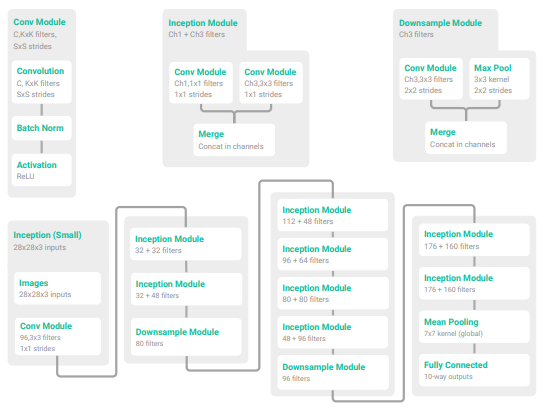

# Define Modules

In [5]:
# convolution module
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU() # ReLU
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs) # convolution
        self.batchnorm = nn.BatchNorm2d(out_channels) # batch normalization

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

# inception module
class inception_block(nn.Module):
    def __init__(self, in_channels, out_ch1, out_ch3):
        super(inception_block, self).__init__()
        # first conv module, padding should be 'same'
        self.ch1 = conv_block(in_channels=in_channels, out_channels=out_ch1, kernel_size=(1,1), stride=(1,1), padding='same')
        # second conv module, passing should be 'same' to enable concatenation
        self.ch3 = conv_block(in_channels=in_channels, out_channels=out_ch3, kernel_size=(3,3), stride=(1,1), padding='same')

    def forward(self,x):
        # concatenate convolution outputs
        return torch.cat([self.ch1(x),self.ch3(x)],1)

# downsample module
class downsample_block(nn.Module):
    def __init__(self, in_channels, conv_out):
        super(downsample_block, self).__init__()
        # conv module
        self.convblock = conv_block(in_channels, conv_out, kernel_size=(3,3), stride=(2,2))
        # max pooling
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2))

    def forward(self,x):
        return torch.cat([self.convblock(x),self.maxpool(x)],1)

# the mini GoogLeNet
class mini_GoogLeNet(nn.Module):
    def __init__(self,in_channels=3, num_classes=10, dropout_prob=0):
        super(mini_GoogLeNet, self).__init__()
        self.conv1 = conv_block(in_channels=3, out_channels=96, kernel_size=(3,3), stride=(1,1))
        self.inception1 = inception_block(96,32,32)
        self.inception2 = inception_block(64,32,48)
        self.downsample1 = downsample_block(80,80)
        self.inception3 = inception_block(160,112,48)
        self.inception4 = inception_block(160,96,64)
        self.inception5 = inception_block(160,80,80)
        self.inception6 = inception_block(160,48,96)
        self.downsample2 = downsample_block(144,96)
        self.inception7 = inception_block(240,176,160)
        self.inception8 = inception_block(336,176,160)
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), padding=(1,1))
        self.dropout = nn.Dropout(p = dropout_prob)
        self.fc = nn.Linear(336,10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.downsample1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.downsample2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Define model

In [6]:
# create the model
model = mini_GoogLeNet(in_channels=3, num_classes=10, dropout_prob=0).to(device=device)

# parameter settings
loss_function = nn.CrossEntropyLoss() # loss funtion
optimizer = optim.SGD(model.parameters(), lr=lr) # optimizer
scheduler = optim.lr_scheduler.LinearLR(optimizer) # scheduler

# Define train() Method

In [7]:
def train(epoch):
    model.train() # start training process
    curr_loss_train = 0 # initialize loss
    correct_train = 0 # initialize number of correct classifications
    total_train = 0 # total number of training points

    for ind, (data_train, true_labels_train) in enumerate(train_loader):
        data_train = data_train.to(device=device) # use GPU
        true_labels_train = true_labels_train.to(device=device) # use GPU

        out_train = model(data_train) # apply model to training data
        loss_train = loss_function(out_train, true_labels_train) # get loss

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        curr_loss_train += loss_train.item()
        ix, predicted_train = out_train.max(1)
        correct_train += predicted_train.eq(true_labels_train).sum().item()
        total_train += true_labels_train.size(0)

    train_loss = curr_loss_train/len(train_loader) # get loss
    acc_train_val = (correct_train/total_train)*100 # get accuracy

    train_acc.append(acc_train_val)
    train_all_loss.append(train_loss)



# Define test() Method

In [8]:
def test(epoch):
    model.eval()
    curr_loss_test = 0 # loss
    correct_test = 0 # correctly classified test points
    total_test = 0 # total number of test points

    num_class = 10
    confusion_matrix = torch.zeros(num_class, num_class)
    with torch.no_grad():
        for data_test, true_labels_test in test_loader:

            data_test = data_test.to(device=device) # use GPU
            true_labels_test = true_labels_test.to(device=device) # use GPU

            out_test = model(data_test) # apply model to training data
            loss_test = loss_function(out_test, true_labels_test) # get loss

            # metrics
            curr_loss_test += loss_test.item()
            ix, predicted_test = out_test.max(1)
            correct_test += predicted_test.eq(true_labels_test).sum().item()
            total_test += true_labels_test.size(0)


    test_loss = curr_loss_test/len(test_loader) # get loss
    acc_test_val = (correct_test/total_test)*100 # get accuracy

    test_acc.append(acc_test_val)
    test_all_loss.append(test_loss)
    con_mats.append(confusion_matrix)

# Initialize arrays

In [9]:
train_acc = []
train_all_loss = []

test_acc = []
test_all_loss = []

con_mats = []

times = []
train_times = []

# Training Proper

In [10]:
train_start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    print(f"Epoch {epoch}")
    train(epoch)
    test(epoch)
    scheduler.step()

    epoch_time = time.time() - ep_start
    print(f"Epoch run time: {epoch_time:0.2f} s")
    times.append(epoch_time)

train_time = time.time() - train_start

print(f"Training time: {train_time:0.2f} s")

Epoch 0
Epoch run time: 23.32 s
Epoch 1
Epoch run time: 23.86 s
Epoch 2
Epoch run time: 22.70 s
Epoch 3
Epoch run time: 22.78 s
Epoch 4
Epoch run time: 22.99 s
Epoch 5
Epoch run time: 23.01 s
Epoch 6
Epoch run time: 22.75 s
Epoch 7
Epoch run time: 22.70 s
Epoch 8
Epoch run time: 22.87 s
Epoch 9
Epoch run time: 22.93 s
Epoch 10
Epoch run time: 22.81 s
Epoch 11
Epoch run time: 22.68 s
Epoch 12
Epoch run time: 23.11 s
Epoch 13
Epoch run time: 23.07 s
Epoch 14
Epoch run time: 22.90 s
Epoch 15
Epoch run time: 22.84 s
Epoch 16
Epoch run time: 22.62 s
Epoch 17
Epoch run time: 22.90 s
Epoch 18
Epoch run time: 22.90 s
Epoch 19
Epoch run time: 23.07 s
Epoch 20
Epoch run time: 22.78 s
Epoch 21
Epoch run time: 22.73 s
Epoch 22
Epoch run time: 22.93 s
Epoch 23
Epoch run time: 22.94 s
Epoch 24
Epoch run time: 22.92 s
Epoch 25
Epoch run time: 22.69 s
Epoch 26
Epoch run time: 22.86 s
Epoch 27
Epoch run time: 23.24 s
Epoch 28
Epoch run time: 22.87 s
Epoch 29
Epoch run time: 22.86 s
Epoch 30
Epoch run t

# Export Results

In [11]:
# save all results to a dataframe for export
df_res = pd.DataFrame()
df_res['train_acc'] = train_acc
df_res['train_all_loss'] = train_all_loss
df_res['test_acc'] = test_acc
df_res['test_all_loss'] = test_all_loss
df_res['times'] = times
df_res['train_time'] = train_time

df_res.to_csv('res_dropout_0.csv', index=False)

# Export Confusion Matrix

In [12]:
# export all confusion matrices to a pickle
with open('con_mats_dropout0.pickle','wb') as handle:
    pickle.dump(con_mats, handle)

# Display Results

In [13]:
pd.set_option('display.max_rows', None)
df_res

,train_acc,train_all_loss,test_acc,test_all_loss,times,train_time
0,34.9725,1.921033,45.67,1.597604,23.318657,1832.100812
1,52.4975,1.388604,56.25,1.257820,23.856418,1832.100812
2,61.1950,1.130634,61.88,1.108428,22.695202,1832.100812
3,66.7900,0.961042,68.72,0.910996,22.775604,1832.100812
4,71.3975,0.831916,67.17,0.964346,22.986386,1832.100812
5,75.2400,0.721936,73.13,0.772109,23.006068,1832.100812
6,79.3350,0.610917,73.87,0.752794,22.748789,1832.100812
7,82.2000,0.529615,71.47,0.872264,22.699038,1832.100812
8,85.0650,0.447563,72.33,0.837417,22.872714,1832.100812
9,87.6400,0.376247,73.12,0.842002,22.928789,1832.100812


# Test Accuracy

In [15]:
max_accuracy = df_res['test_acc'].max()
print(f"Highest accuracy reached: {max_accuracy}%")

Highest accuracy reached: 81.88%
